In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
county_np = np.loadtxt('county_matrix.csv', delimiter=',', dtype=int)
map_fips = np.unique(county_np)

In [3]:
dict_dict = {}

census_df = pd.read_csv('census.csv').set_index('FIPS')
census_pct = census_df.rank(pct=True)
display(census_df.head())
display(census_pct.head())

dict_dict['pop_density'] = census_pct['pop_density'].to_dict()

,POPESTIMATE2019,sq_miles,pop_density
FIPS,,,
1001,55869,633,88.260664
1003,223234,1742,128.148106
1005,24686,932,26.487124
1007,22394,643,34.827372
1009,57826,682,84.788856


,POPESTIMATE2019,sq_miles,pop_density
FIPS,,,
1001,0.706885,0.482465,0.701737
1003,0.902188,0.891248,0.770592
1005,0.482947,0.725064,0.361969
1007,0.454311,0.493565,0.438546
1009,0.714607,0.533784,0.689833


In [4]:
scale=0.9

def calc_matrix(dict_type, lum=1):
    scale=0.9

    img_np = np.zeros([county_np.shape[0], county_np.shape[1]])

    for row in np.arange(0, county_np.shape[0]):
        for col in np.arange(0, county_np.shape[1]):
            if county_np[row, col] != 0:
                try:
                    img_np[row, col] = dict_dict[dict_type][county_np[row, col]]*scale*lum+1-scale
                except KeyError:
                    img_np[row, col] = 0.05    
    return img_np


In [5]:
def plot_img(image, series, color, title, export_name, round_int=False, clip=None, cbar_index=None, lum=1, bkgd=None):
    plt.rcParams["figure.figsize"] = (16,8)

    try:
        colors = cm.get_cmap(color, 100)
    except:
        colors = color
    base_colors = colors(np.linspace(0, 1, int(100/lum)))[:100]
    if clip == 1:
        base_colors[:9, :] = np.array([0.5, 0.5, 0.5, 1])
        base_colors[9:11, :] = np.array([0, 0, 0, 1])
        base_colors[11:, :] = colors(np.linspace(0, 1, 89))
    elif clip == 0:
        base_colors[:10, :] = np.array([0.5, 0.5, 0.5, 1])
        base_colors[10:, :] = colors(np.linspace(0, 1, 90))
    base_cm = ListedColormap(base_colors)

    new_colors = base_colors.copy()
    if bkgd is None:
        new_colors[:5, :] = np.array([0.1, 0.1, 0.1, 1])
    else:
        new_colors[:5, :] = bkgd
    new_colors[5:10, :] = np.array([0.5, 0.5, 0.5, 1])
    new_colors[10:, :] = colors(np.linspace(0, 1, 90))
    if clip:
        new_colors[10, :] = np.array([0, 0, 0, 1])
    custom_cm = ListedColormap(new_colors)

    county_img = custom_cm(image)

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('miles')
    ax.set_ylabel('miles')
    im = ax.imshow(county_img, cmap=base_cm)
    cbar = plt.colorbar(im, ax=ax)
    if clip is None:
        cbar.set_ticks(list(np.linspace(0.05,1,11)))
        cbar.set_ticklabels(list(np.linspace(min(series), max(series), 11).round(4)))
    else:
        cbar.set_ticks([0.05] + list(np.linspace(1-scale,1,10)))
        cbar.set_ticklabels(['no data'] + list(np.linspace(min(series), max(series), 10).round(4)))
        if round_int:
            cbar.set_ticklabels(['no data'] + list(np.linspace(min(series), max(series), 10).astype(int)))
    if cbar_index is not None:
        cbar.set_ticklabels(cbar_index)
    plt.show()
    fig.savefig(export_name)


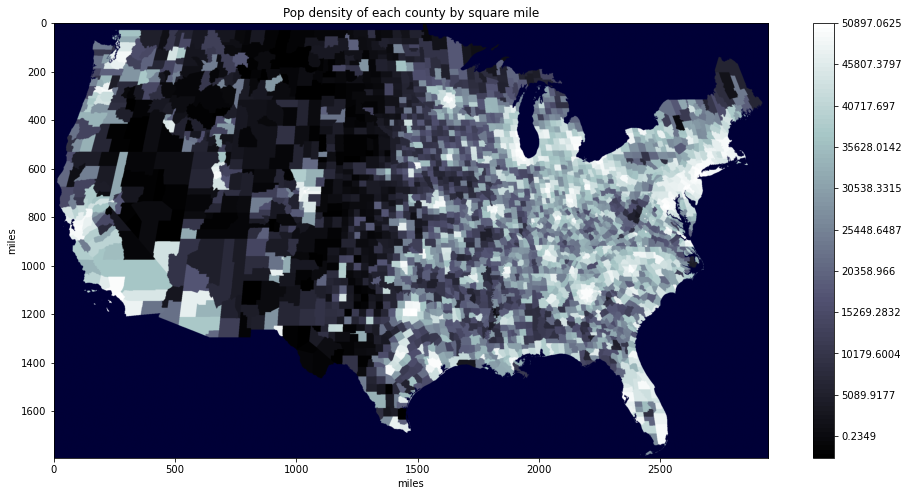

In [6]:
pop_density_img = calc_matrix('pop_density')
plot_img(pop_density_img, census_df['pop_density'], 'bone', \
         'Pop density of each county by square mile', 'data_pop_density.png', bkgd=np.array([0, 0, 55/255, 1]))

In [7]:
corona_df = pd.read_csv('corona.csv').set_index('FIPS')
corona_df = corona_df[corona_df.index.isin(map_fips)]
corona_df['pct_cases'] = corona_df.cases_now/corona_df.POPULATION
display(corona_df.head())
corona_pct = corona_df.rank(pct=True)
display(corona_pct.head())

dict_dict['cases_now'] = corona_pct['cases_now'].dropna().to_dict()
dict_dict['pct_cases'] = corona_pct['pct_cases'].dropna().to_dict()

,cases_now,cases_old,POPULATION,pct_cases
FIPS,,,,
1001,67.0,36.0,55869,0.001199
1003,208.0,147.0,223234,0.000932
1005,53.0,32.0,24686,0.002147
1007,44.0,34.0,22394,0.001965
1009,44.0,31.0,57826,0.000761


,cases_now,cases_old,POPULATION,pct_cases
FIPS,,,,
1001,0.658232,0.627730,0.685615,0.606586
1003,0.820971,0.826516,0.896014,0.533102
1005,0.615771,0.607279,0.445754,0.756672
1007,0.585789,0.617158,0.414905,0.736915
1009,0.585789,0.602253,0.693934,0.456846


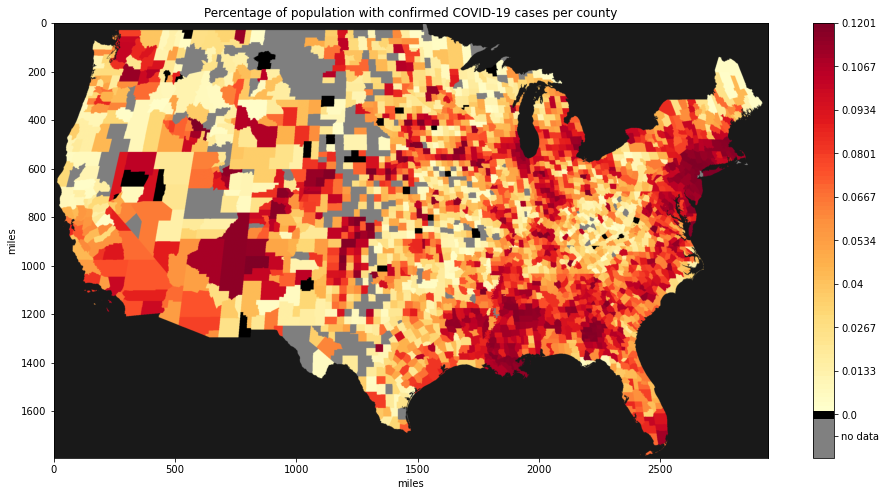

In [8]:
pct_cases_img = calc_matrix('pct_cases')
plot_img(pct_cases_img, corona_df['pct_cases'], 'YlOrRd', \
         'Percentage of population with confirmed COVID-19 cases per county', 'data_cases_pct.png', clip=1)

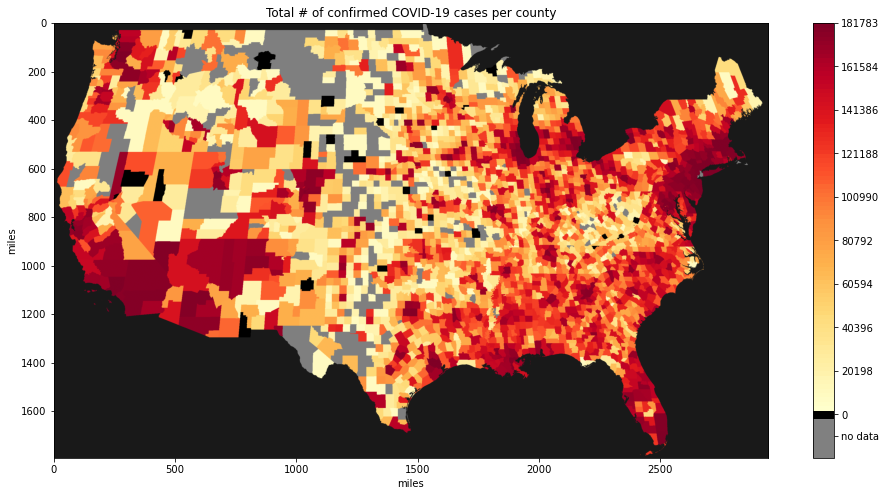

In [9]:
total_cases_img = calc_matrix('cases_now')
plot_img(total_cases_img, corona_df['cases_now'], 'YlOrRd', \
         'Total # of confirmed COVID-19 cases per county', 'data_cases_total.png', round_int=True, clip=1)

In [10]:
param_df = pd.read_csv('params.csv').set_index('FIPS')
display(param_df)
param_df_pct = param_df.rank(pct=True)
display(param_df_pct)
dict_dict['SUSCEPTIBLE'] = param_df_pct['SUSCEPTIBLE'].to_dict()
dict_dict['INFECTED'] = param_df_pct['INFECTED'].to_dict()
dict_dict['REMOVED'] = param_df_pct['REMOVED'].to_dict()
dict_dict['beta'] = param_df_pct.beta.to_dict()
dict_dict['gamma'] = param_df_pct.gamma.to_dict()

,beta,gamma,SUSCEPTIBLE,INFECTED,REMOVED,US
FIPS,,,,,,
1001,0.000040,0.000025,0.998801,0.000555,0.000644,1
1003,0.000020,0.000028,0.999068,0.000273,0.000659,1
1005,0.000061,0.000074,0.997853,0.000851,0.001296,1
1007,0.000032,0.000067,0.998035,0.000447,0.001518,1
1009,0.000016,0.000026,0.999239,0.000225,0.000536,1
...,...,...,...,...,...,...
56037,0.000005,0.000018,0.999551,0.000071,0.000378,1
56039,0.000009,0.000139,0.995823,0.000128,0.004049,1
56041,0.000036,0.000034,0.999555,0.000099,0.000346,1


,beta,gamma,SUSCEPTIBLE,INFECTED,REMOVED,US
FIPS,,,,,,
1001,0.630952,0.418597,0.440798,0.723616,0.573359,0.500161
1003,0.205277,0.476834,0.509974,0.555663,0.581403,0.500161
1005,0.779279,0.855212,0.224582,0.802445,0.764801,0.500161
1007,0.517375,0.839125,0.283462,0.669562,0.805019,0.500161
1009,0.171815,0.432432,0.581725,0.507400,0.501609,0.500161
...,...,...,...,...,...,...
56037,0.030888,0.242278,0.741313,0.248069,0.370656,0.500161
56039,0.077220,0.931467,0.104891,0.375161,0.945302,0.500161
56041,0.577220,0.570142,0.742600,0.313063,0.331081,0.500161


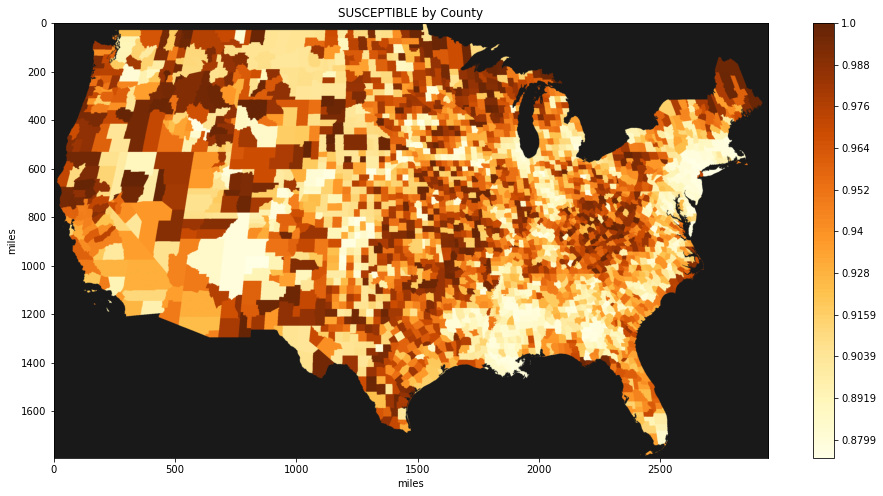

In [11]:
s_img = calc_matrix('SUSCEPTIBLE')
plot_img(s_img, param_df['SUSCEPTIBLE'], 'YlOrBr', \
         'SUSCEPTIBLE by County', 'data_S.png')

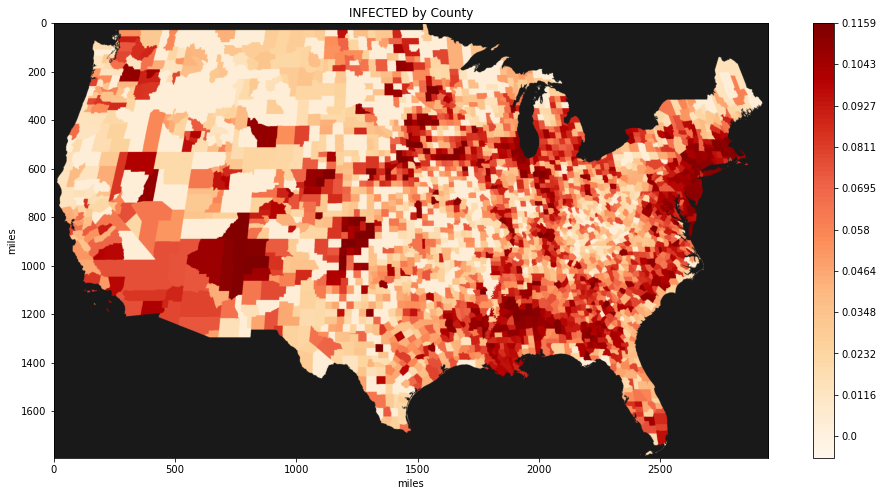

In [12]:
i_img = calc_matrix('INFECTED')
plot_img(i_img, param_df['INFECTED'], 'OrRd', \
         'INFECTED by County', 'data_I.png')

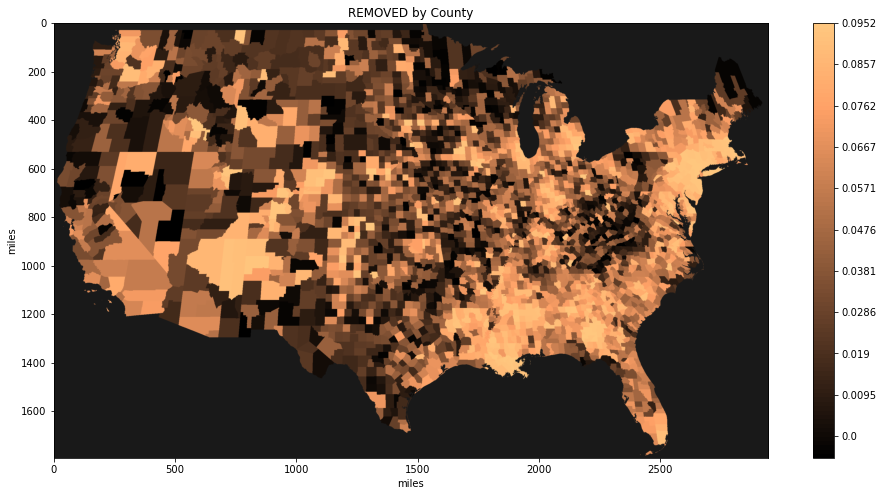

In [13]:
r_img = calc_matrix('REMOVED')
plot_img(r_img, param_df['REMOVED'], 'copper', \
         'REMOVED by County', 'data_R.png')

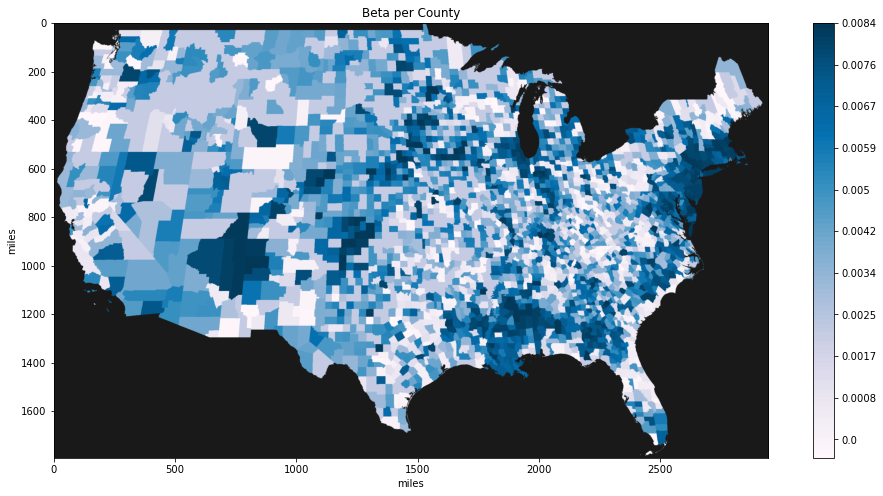

In [14]:
beta_img = calc_matrix('beta')
plot_img(beta_img, param_df['beta'], 'PuBu', \
         'Beta per County', 'data_beta.png')

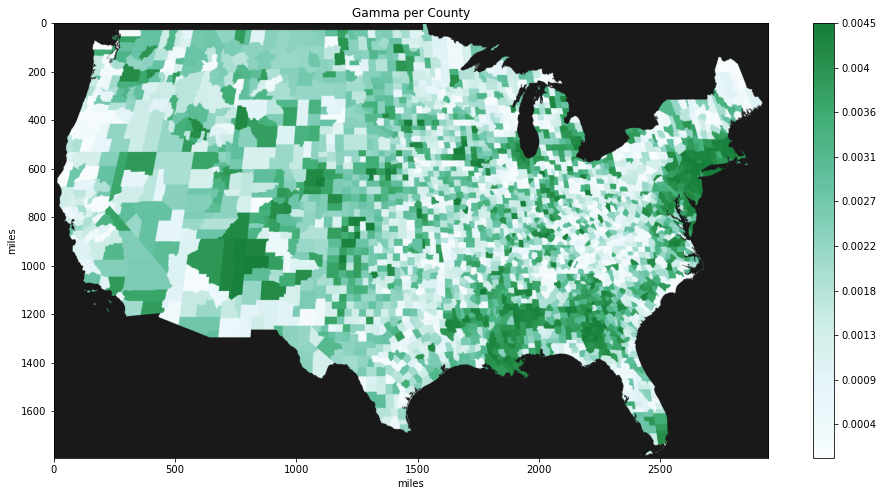

In [15]:
gamma_img = calc_matrix('gamma', lum=0.8)
plot_img(gamma_img, param_df['gamma'], 'BuGn', \
         'Gamma per County', 'data_gamma.png', lum=0.8)

In [16]:
beta_gamma_ratio = param_df.beta/param_df.gamma
beta_gamma_ratio_pct = beta_gamma_ratio[beta_gamma_ratio<1].rank(pct=True)/2
beta_gamma_ratio_pct = beta_gamma_ratio_pct.append(beta_gamma_ratio[beta_gamma_ratio>=1].rank(pct=True)/2+0.5)
dict_dict['beta_gamma_ratio'] = beta_gamma_ratio_pct.to_dict()

gamma_beta = beta_gamma_ratio[beta_gamma_ratio<=1]
beta_gamma = beta_gamma_ratio[beta_gamma_ratio>=1]
beta_gamma_cbar_index = [(max(gamma_beta)-min(gamma_beta))/5*i + min(gamma_beta) for i in range(6)][:5]
beta_gamma_cbar_index += [(max(beta_gamma)-min(beta_gamma))/5*i + min(beta_gamma) for i in range(6)]
beta_gamma_cbar_index

[0.023809523809523593,
 0.21904761904761885,
 0.41428571428571415,
 0.6095238095238095,
 0.8047619047619047,
 1.0,
 25.31428571428571,
 49.62857142857142,
 73.94285714285712,
 98.25714285714284,
 122.57142857142856]

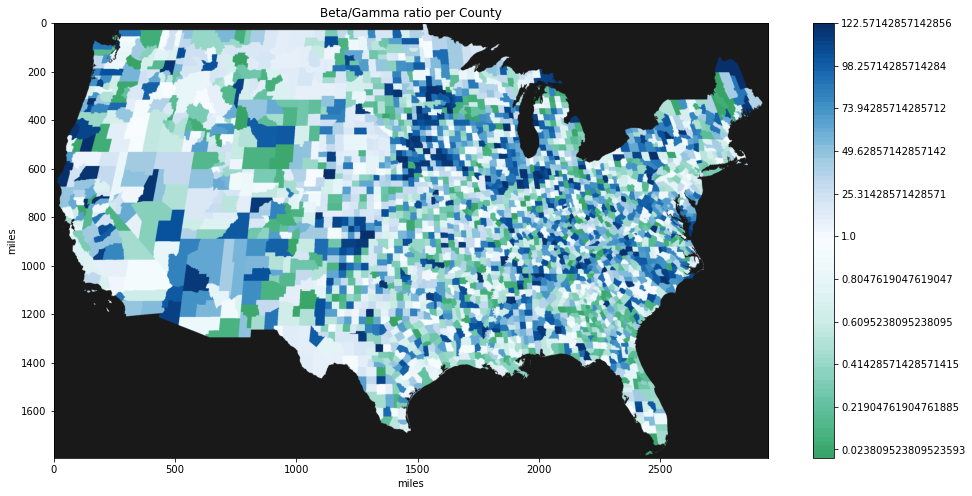

In [17]:
color1 = cm.get_cmap('BuGn_r', 128)
color2 = cm.get_cmap('Blues', 128)
newcolors = np.vstack((color1(np.linspace(0, 1, 96)[-64:]),
                       color2(np.linspace(0, 1, 64))))
newcmp = ListedColormap(newcolors, name='beta_gamma')

beta_gamma_img = calc_matrix('beta_gamma_ratio')
plot_img(beta_gamma_img, beta_gamma_ratio_pct, newcmp, \
         'Beta/Gamma ratio per County', 'data_beta_gamma.png', cbar_index=beta_gamma_cbar_index)